In [3]:
# libraries
from pymongo import MongoClient
import pandas as pd
import pickle
import re
from unidecode import unidecode
from string import whitespace, punctuation
from fuzzywuzzy import process

In [4]:
# open the client
client = MongoClient()
db = client.lon_db
db.collection_names()
collection = db.lon_docs

In [5]:
# get the first ten lines of each textbody so I can find the date
doc_list = []

for doc in collection.find({'languageCode':'en'},
                          {'_id':0,
                           'publicationDate':1,'symbol':1,'body_en':1}):
        text = doc['body_en']
        lines_10 = text.split('\n')[:10]
        doc['body_en'] = lines_10
        doc_list.append(doc)

In [6]:
# let's take a look at the data.
doc_list[0]

{u'body_en': [u'',
  u'LEAGUE OF NATIONS.',
  u'',
  u'C.476.1930.X.',
  u'',
  u'Geneva, September 6th, 1930,',
  u'',
  u'CONTRIBUTIONS IN ARREARS.',
  u'',
  u'the Cuban Representative. '],
 u'publicationDate': u'1930-01-01T00:00:01Z',
 u'symbol': u'C.476.1930.X'}

In [7]:
# let's find ecerything in the lines that has a number

def get_number_lines(line_list):
    '''
    
    '''
    has_number_list = []
    
    has_number = re.compile('\d')
    
    for i in range(len(line_list)):
        line = unidecode(line_list[i])
        no_space = line.translate(None, whitespace)
        if re.search(has_number, line) != None:
            has_number_list.append((i, no_space))
        
    return has_number_list

In [50]:
# let's test this function out

test_1 = doc_list[0]['body_en']
test_2 = doc_list[300]['body_en']
test_3 = doc_list[2000]['body_en']

print get_number_lines(test_1)
print '-----------------'
print get_number_lines(test_2)
print '-----------------'
print get_number_lines(test_3)
print '-----------------'

[(4, 'Geneva,September6th,1930,')]
-----------------
[(3, '0.86.1935.VII.'), (6, 'theCouncil.Geneva,February1st,1935.')]
-----------------
[(1, 'LEAGUE0?NATIONS.'), (3, 'GcmnunlcatedtotheC.623.M.295.1933.VII.'), (5, 'MembersoftheLeague.Geneva,October31st,1933.')]
-----------------


In [13]:
def find_geneva(line_list):
    '''
    '''
    has_number = get_number_lines(line_list) #remember returns tuples
        
    start_Ge = re.compile('Ge')
    
    has_geneva = []
    
    for line in has_number:
        if re.search(start_Ge, line[1]) != None:
            has_geneva.append(line)
    
    if len(has_geneva) == 1:
        has_geneva_text = has_geneva[0][1]
        if start_Ge.match(has_geneva_text) == None:
            pass
    
    
    return has_geneva

In [14]:
# let's test this function out

test_1 = doc_list[0]['body_en']
test_2 = doc_list[300]['body_en']
test_3 = doc_list[2000]['body_en']

print find_geneva(test_1)
print '-----------------'
print find_geneva(test_2)
print '-----------------'
print find_geneva(test_3)

[(5, 'Geneva,September6th,1930,')]
-----------------
[(6, 'theCouncil.Geneva,February1st,1935.')]
-----------------
[(5, 'MembersoftheLeague.Geneva,October31st,1933.')]


In [18]:
def add_dateline_to_docs(doc_list):
    '''
    
    '''
    for doc in doc_list:
        dateline = find_geneva(doc['body_en'])
        doc['dateline'] = dateline
    return doc_list

In [66]:
# let's test this function out

test_1 = doc_list[0]['body_en']
test_2 = doc_list[300]['body_en']
test_3 = doc_list[2000]['body_en']

print add_dateline_to_docs(test_1)
print '-----------------'
print add_dateline_to_docs(test_2)
print '-----------------'
print add_dateline_to_docs(test_3)

TypeError: string indices must be integers

In [20]:
doc_list_dateline = add_dateline_to_docs(doc_list)

In [21]:
doc_list_dateline[9]['dateline']

[(7, "Geneva,September2'/th,1934*")]

In [22]:
# let's see how well I did
one_dateline = 0
multi_dateline = 0
no_datelike = 0

for doc in doc_list_dateline:
    if len(doc['dateline']) == 1:
        one_dateline += 1
    elif len(doc['dateline']) > 1:
        multi_dateline += 1
    else:
        no_datelike += 1

print one_dateline
print multi_dateline
print no_datelike

6884
49
4985


Now the thing I want to do is to label each line as dateline or non-dateline or other thing

In [23]:
print test_1

[u'', u'LEAGUE OF NATIONS.', u'', u'C.476.1930.X.', u'', u'Geneva, September 6th, 1930,', u'', u'CONTRIBUTIONS IN ARREARS.', u'', u'the Cuban Representative. ']


In [24]:
[unidecode(i) for i in test_1 if i != '']

['LEAGUE OF NATIONS.',
 'C.476.1930.X.',
 'Geneva, September 6th, 1930,',
 'CONTRIBUTIONS IN ARREARS.',
 'the Cuban Representative. ']

In [25]:
[unidecode(i) for i in test_2 if i != '']

['LEAGUE OF NATIONS',
 '0.86.1935.VII.',
 'Communicated to',
 'the Council. Geneva, February 1st, 1935.',
 'FREE CITY OF DANZIG ']

In [26]:
[unidecode(i) for i in test_3 if i != '']

['LEAGUE 0? NATIONS .',
 'Gcmnunlcated to the C. 623. M. 295.1933. VII.',
 'Council and the',
 'Members of the League. Geneva, October 31st, 1933.',
 'SAAR BASIN.',
 'Petition from the Union of German Newspaper Pub I ishers,']

In [34]:
# find the symbol line
# I think that this might be going too far because I have the symbol anyway
# it might be nice to see it in the wild

def find_symbol_line(line_list, symbol):
    '''
    
    '''
    line_list = [unidecode(i) for i in line_list]
    
    #no_space_line_list = [i.translate(None,whitespace) for i in no_empty_line_list]
    
    symbolline = process.extractOne(unidecode(symbol), line_list)
    
    if symbolline != None:
        line_number = line_list.index(symbolline[0])
        return (line_number, unidecode(symbolline[0]))
        

In [35]:
test_1

[u'',
 u'LEAGUE OF NATIONS.',
 u'',
 u'C.476.1930.X.',
 u'',
 u'Geneva, September 6th, 1930,',
 u'',
 u'CONTRIBUTIONS IN ARREARS.',
 u'',
 u'the Cuban Representative. ']

In [ ]:
test_1.index()

In [36]:
# let's test this function out

test_1 = doc_list[0]['body_en']
symbol_1 = unidecode(doc_list[0]['symbol'])
test_2 = doc_list[300]['body_en']
symbol_2 = unidecode(doc_list[300]['symbol'])
test_3 = doc_list[2000]['body_en']
symbol_3 = symbol_2 = unidecode(doc_list[2000]['symbol'])

print find_symbol_line(test_1, symbol_1)
print '-----------------'
print find_symbol_line(test_2, symbol_2)
print '-----------------'
print find_symbol_line(test_3, symbol_3)

(3, 'C.476.1930.X.')
-----------------
(3, '0.86.1935.VII.')
-----------------
(3, 'Gcmnunlcated to the C. 623. M. 295.1933. VII.')


/Users/johnkeating/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
/Users/johnkeating/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.


In [39]:
def add_symbolline_to_docs(doc_list):
    '''
    
    '''
    for doc in doc_list:
        line_list = doc['body_en']
        symbol = doc['symbol']
        
        symbolline = find_symbol_line(line_list, symbol)
        
        if symbolline == None:
            pass
            
        elif len(symbolline[1]) < 3:
            pass
        
        else:
            doc['symbolline'] = symbolline
    
    return doc_list

In [40]:
doc_list_symbolline = add_symbolline_to_docs(doc_list_dateline)

/Users/johnkeating/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.


In [42]:
print doc_list_symbolline[0]['symbolline']
print doc_list_symbolline[3333]['symbolline']
print doc_list_symbolline[360]['symbolline']
print doc_list_symbolline[450]['symbolline']

(3, 'C.476.1930.X.')
(5, 'Official No. : C. S55. M. 226. 1931. IX. ')


KeyError: 'symbolline'

In [43]:
no_symbolline = 0
has_symbolline = 0

for doc in doc_list_symbolline:
    if 'symbolline' in doc.keys():
        has_symbolline += 1
    else:
        no_symbolline += 1

print has_symbolline
print no_symbolline
print has_symbolline + no_symbolline

11868
50
11918


In [44]:
doc_list_symbolline[0]

{u'body_en': [u'',
  u'LEAGUE OF NATIONS.',
  u'',
  u'C.476.1930.X.',
  u'',
  u'Geneva, September 6th, 1930,',
  u'',
  u'CONTRIBUTIONS IN ARREARS.',
  u'',
  u'the Cuban Representative. '],
 'dateline': [(5, 'Geneva,September6th,1930,')],
 u'publicationDate': u'1930-01-01T00:00:01Z',
 u'symbol': u'C.476.1930.X',
 'symbolline': (3, 'C.476.1930.X.')}

In [51]:
indices = 3,4
[i for j, i in enumerate(test_1) if j not in indices]

[u'',
 u'LEAGUE OF NATIONS.',
 u'',
 u'',
 u'CONTRIBUTIONS IN ARREARS.',
 u'',
 u'the Cuban Representative. ']

In [54]:
test_list = []
for i in test_1:
    test_list.append([i,'other'])

test_list

[[u'', 'other'],
 [u'LEAGUE OF NATIONS.', 'other'],
 [u'', 'other'],
 [u'', 'other'],
 [u'Geneva, September 6th, 1930,', 'other'],
 [u'', 'other'],
 [u'CONTRIBUTIONS IN ARREARS.', 'other'],
 [u'', 'other'],
 [u'the Cuban Representative. ', 'other']]

In [64]:
test_1

[u'',
 u'LEAGUE OF NATIONS.',
 u'',
 u'',
 u'Geneva, September 6th, 1930,',
 u'',
 u'CONTRIBUTIONS IN ARREARS.',
 u'',
 u'the Cuban Representative. ']

In [77]:
def label_lines(line_list, symbol, symbolline, dateline):
    
    symbol = unidecode(symbol)
    
    label_list = []
    
    rm_lines = [symbolline[0], dateline[0]]
    
    other_lines = [i for j, i in enumerate(line_list) if j not in rm_lines]
    
    no_empties = [i for i in other_lines if i != '']
    
    label_list.append([symbol, symbolline[1], 'symbolline'])
    
    label_list.append([symbol, dateline[1], 'dateline'])
    
    for line in no_empties:
        label_list.append([symbol, unidecode(line),'other'])
    
    return label_list

In [69]:
test_1 = doc_list[0]['body_en']
test_1

[u'',
 u'LEAGUE OF NATIONS.',
 u'',
 u'',
 u'Geneva, September 6th, 1930,',
 u'',
 u'CONTRIBUTIONS IN ARREARS.',
 u'',
 u'the Cuban Representative. ']

In [70]:
label_lines(test_1, 'C.476.1930.X.',(3, 'C.476.1930.X.'),[(4, 'Geneva,September6th,1930,')])

/Users/johnkeating/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.


[['C.476.1930.X.', 'C.476.1930.X.', 'symbolline'],
 ['C.476.1930.X.', 'Geneva,September6th,1930,', 'dateline'],
 ['C.476.1930.X.', 'LEAGUE OF NATIONS.', 'other'],
 ['C.476.1930.X.', 'CONTRIBUTIONS IN ARREARS.', 'other'],
 ['C.476.1930.X.', 'the Cuban Representative. ', 'other']]

In [ ]:
test_2 = doc_list[300]['body_en']

In [73]:
test_label_list = label_lines(doc_list[300]['body_en'], doc_list[300]['symbol'], doc_list[300]['symbolline'],doc_list[300]['dateline'])

In [74]:
pd.DataFrame(test_label_list, columns=['symbol', 'line', 'category'])

,symbol,line,category
0,C.86.1935.VII,0.86.1935.VII.,symbolline
1,C.86.1935.VII,"theCouncil.Geneva,February1st,1935.",dateline
2,C.86.1935.VII,LEAGUE OF NATIONS,other
3,C.86.1935.VII,Communicated to,other
4,C.86.1935.VII,FREE CITY OF DANZIG,other


In [85]:
def create_labeled_data(doc_list):
    '''
    '''
    
    main_list = []
    
    for doc in doc_list:
        if 'symbolline' in doc.keys() and 'dateline' in doc.keys():
            if len(doc['dateline']) == 1:
                
                line_list = doc['body_en']
                symbol = doc['symbol']
                symbolline = doc['symbolline']
                dateline = doc['dateline'][0]
                
                label_list = label_lines(line_list, symbol, symbolline, dateline)
                
                for i in label_list:
                    main_list.append(i)
    
    return pd.DataFrame(main_list, columns=['symbol', 'line', 'type'])
    

In [87]:
label_df = create_labeled_data(doc_list_symbolline)

In [89]:
label_df['line'] = label_df['line'].apply(lambda x: x.translate(None, whitespace))

In [90]:
label_df.head()

,symbol,line,type
0,C.476.1930.X,C.476.1930.X.,symbolline
1,C.476.1930.X,"Geneva,September6th,1930,",dateline
2,C.476.1930.X,LEAGUEOFNATIONS.,other
3,C.476.1930.X,"Geneva,September6th,1930,",other
4,C.476.1930.X,CONTRIBUTIONSINARREARS.,other


In [98]:
label_df['line'] = label_df['line'].apply(lambda x: x.encode('utf-8'))

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [110]:
%matplotlib inline
import matplotlib as mlt
import matplotlib.pyplot as plt

In [102]:
# turn each line into a vector

vectorizer = TfidfVectorizer()

text_list = list(label_df['line'])


X = vectorizer.fit_transform(text_list)

In [105]:
type_dictionary = {'symbolline':2,
                  'dateline':1,
                  'other':0}

In [106]:
label_df['type_code'] = label_df['type'].map(type_dictionary)

In [107]:
label_df.head()

,symbol,line,type,type_code
0,C.476.1930.X,C.476.1930.X.,symbolline,2
1,C.476.1930.X,"Geneva,September6th,1930,",dateline,1
2,C.476.1930.X,LEAGUEOFNATIONS.,other,0
3,C.476.1930.X,"Geneva,September6th,1930,",other,0
4,C.476.1930.X,CONTRIBUTIONSINARREARS.,other,0


In [108]:
Y = label_df['type']

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.30, random_state=4444)

KNN (n=1) accuracy: 0.6302
KNN (n=2) accuracy: 0.8425
KNN (n=3) accuracy: 0.8709
KNN (n=4) accuracy: 0.6285
KNN (n=5) accuracy: 0.6506
KNN (n=6) accuracy: 0.6268
KNN (n=7) accuracy: 0.6445
KNN (n=8) accuracy: 0.6311
KNN (n=9) accuracy: 0.6513
KNN (n=10) accuracy: 0.6398
KNN (n=11) accuracy: 0.6667
KNN (n=12) accuracy: 0.6472
KNN (n=13) accuracy: 0.8788
KNN (n=14) accuracy: 0.8811
KNN (n=15) accuracy: 0.8827
KNN (n=16) accuracy: 0.8836
KNN (n=17) accuracy: 0.8853
KNN (n=18) accuracy: 0.8849
KNN (n=19) accuracy: 0.8853
-----------------------
KNN max accuracy: 0.8853


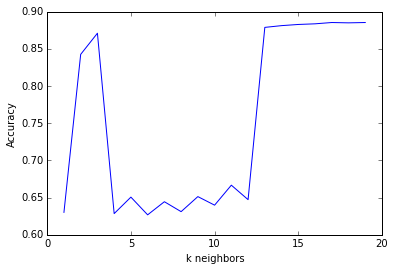

In [119]:
accs = []
for n in range(1,20):
    model = KNeighborsClassifier(n_neighbors=n, metric='cosine', algorithm='brute').fit(X_train,Y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_test_pred)
    accs.append(accuracy)
    print 'KNN (n=%i) accuracy: %.4f' % (n,accuracy)

print '-----------------------'
print 'KNN max accuracy: %.4f' % max(accs)
plt.plot(range(1,20), accs)
plt.xlabel('k neighbors')
plt.ylabel('Accuracy')


In [120]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier().fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
print 'Decision Tree accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Decision Tree accuracy: 0.8969


In [121]:
from sklearn.svm import SVC
model = SVC().fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
print 'SVM Classifier accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

SVM Classifier accuracy: 0.6416


In [122]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
print 'Random Forest accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Random Forest accuracy: 0.8997


In [123]:
binary_code_dict = {'symbolline':0,
                  'dateline':1,
                  'other':0}

In [124]:
label_df['binary_code'] = label_df['type'].map(binary_code_dict)

In [125]:
label_df.head()

,symbol,line,type,type_code,binary_code
0,C.476.1930.X,C.476.1930.X.,symbolline,2,0
1,C.476.1930.X,"Geneva,September6th,1930,",dateline,1,1
2,C.476.1930.X,LEAGUEOFNATIONS.,other,0,0
3,C.476.1930.X,"Geneva,September6th,1930,",other,0,0
4,C.476.1930.X,CONTRIBUTIONSINARREARS.,other,0,0


In [126]:
y_2 = label_df['binary_code']

In [133]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y_2, test_size=.30, random_state=4444)

/Users/johnkeating/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.
  app.launch_new_instance()


TypeError: cosine_distances() got an unexpected keyword argument 'analyzer'

In [130]:

from sklearn.naive_bayes import GaussianNB

model = GaussianNB().fit(X_train.toarray(), Y_train)
Y_test_pred = model.predict(X_test.toarray())
print 'Naive Bayes (Gaussian) accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Naive Bayes (Gaussian) accuracy: 0.5539


In [132]:
# this is with the three categories
from sklearn.naive_bayes import GaussianNB

model = GaussianNB().fit(X_train.toarray(), Y_train)
Y_test_pred = model.predict(X_test.toarray())
print 'Naive Bayes (Gaussian) accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Naive Bayes (Gaussian) accuracy: 0.4555


In [134]:
# based on 2 way split
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier().fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
print 'Decision Tree accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Decision Tree accuracy: 0.9614


In [135]:
from sklearn.svm import SVC
model = SVC().fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
print 'SVM Classifier accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

SVM Classifier accuracy: 0.8205


In [136]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
print 'Random Forest accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Random Forest accuracy: 0.9640


I just realized that the results might be biased towards Geneva because of I was searching based on words, which was the default. I changed it to characters below and see just how much the accuracy shot up. This was based on a binary search.

In [139]:
vectorizer = TfidfVectorizer(analyzer='char')

text_list = list(label_df['line'])


X = vectorizer.fit_transform(text_list)

In [140]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y_2, test_size=.30, random_state=4444)

KNN (n=1) accuracy: 0.9606
KNN (n=2) accuracy: 0.9526
KNN (n=3) accuracy: 0.9751
KNN (n=4) accuracy: 0.9729
KNN (n=5) accuracy: 0.9775
KNN (n=6) accuracy: 0.9770
KNN (n=7) accuracy: 0.9769
KNN (n=8) accuracy: 0.9770
KNN (n=9) accuracy: 0.9770
KNN (n=10) accuracy: 0.9768
KNN (n=11) accuracy: 0.9765
KNN (n=12) accuracy: 0.9763
KNN (n=13) accuracy: 0.9763
KNN (n=14) accuracy: 0.9764
KNN (n=15) accuracy: 0.9759
KNN (n=16) accuracy: 0.9761
KNN (n=17) accuracy: 0.9762
KNN (n=18) accuracy: 0.9758
KNN (n=19) accuracy: 0.9758
-----------------------
KNN max accuracy: 0.9775


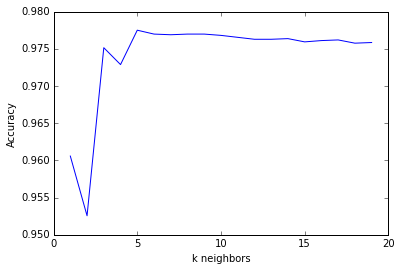

In [141]:
accs = []
for n in range(1,20):
    model = KNeighborsClassifier(n_neighbors=n, metric='cosine', algorithm='brute').fit(X_train,Y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_test_pred)
    accs.append(accuracy)
    print 'KNN (n=%i) accuracy: %.4f' % (n,accuracy)

print '-----------------------'
print 'KNN max accuracy: %.4f' % max(accs)
plt.plot(range(1,20), accs)
plt.xlabel('k neighbors')
plt.ylabel('Accuracy')

In [142]:
model = GaussianNB().fit(X_train.toarray(), Y_train)
Y_test_pred = model.predict(X_test.toarray())
print 'Naive Bayes (Gaussian) accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Naive Bayes (Gaussian) accuracy: 0.8279


The Bayes is much more accurate and it is nearly instantaneous. 

In [145]:
doc_list[3]['dateline']

[]

In [150]:
# create a dataframe with all the lines that have not been tagged

def get_non_tagged_lines(doc_list):
    '''
    I suppose I could make this into one function that spits out one df
    I could then take bits from it.
    '''
    untagged_line_list = []
    for doc in doc_list:
        if doc['dateline'] == []:
            symbol = doc['symbol']
            for line in doc['body_en']:
                if line != '' and len(line) > 4:
                    untagged_line_list.append([symbol,line])
    
    return pd.DataFrame(untagged_line_list, columns=['symbol', 'line'])

In [151]:
untagged_df = get_non_tagged_lines(doc_list)

In [153]:
untagged_df.head()

,symbol,line
0,C.234.1930.II,IJE OF NATIONS.
1,C.234.1930.II,PRELIMIlNi
2,C.234.1930.II,C.234.1930.II.
3,C.234.1930.II,"Geneva,"
4,C.234.1930.II,"April 30th, 1930,"


In [160]:
model = KNeighborsClassifier(n_neighbors=5,
                             metric='cosine',
                             algorithm='brute').fit(X, y_2)



In [165]:
untagged_df['line'] = untagged_df['line'].apply(lambda x: unidecode(x).translate(None, whitespace))

In [168]:
untagged_df[untagged_df['line'] == 'Geneva,']

,symbol,line
3,C.234.1930.II,"Geneva,"
52,C.584.M.356.1922.I,"Geneva,"
57,C.204.1924,"Geneva,"
189,C.503.1935.II.B,"Geneva,"
201,C.540.1931.I,"Geneva,"
207,C.659.M.262.1923.IX,"Geneva,"
211,C.370.1931,"Geneva,"
233,C.202.1926.VII,"Geneva,"
244,C.555.1930.III,"Geneva,"
271,C.402.1924.X,"Geneva,"


In [162]:
untag = vectorizer.fit_transform(untagged_df['line'])

In [163]:
model.predict(untag)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 106 while Y.shape[1] == 66